## 1 Preparation

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import psycopg2
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from collections import Counter
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from imblearn.over_sampling import SMOTE

#Machine Learning Dependencies
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [104]:
# read the tables
data_test = pd.read_csv('aug_test.csv')
data_train = pd.read_csv('aug_train.csv')
data_label = pd.read_csv('sample_submission.csv')

## 2. Explore

> ### Initial Check

In [3]:
# Mengambil 5 data 
data_test.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [4]:
# data type
data_train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [5]:
# Menghitung Jumlah Baris dan Kolom
data_test.shape

(2129, 13)

In [6]:
# Mengecek Fitur yang ada kedalam list
data_test.columns.tolist()

['enrollee_id',
 'city',
 'city_development_index',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'training_hours']

In [7]:
# Menggabungkan data set TEST dan Label
data_gabung = data_test.merge(data_label, on='enrollee_id', how='left')
data_gabung.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21,0.5
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98,0.5
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15,0.5
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39,0.5
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72,0.5


In [8]:
# Menghitung jumlah Unique dari setiap kolom
data_train.apply(lambda x: x.nunique())

enrollee_id               19158
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   22
company_size                  8
company_type                  6
last_new_job                  6
training_hours              241
target                        2
dtype: int64

In [9]:
# Menghilangkan enrollee_id , karena tidak akan membutuhkan enrollee_id

data_train.drop('enrollee_id', axis=1, inplace=True)
data_test.drop('enrollee_id', axis=1, inplace=True)

In [10]:
data_train.describe()

,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000
mean,0.828848,65.366896,0.249348
std,0.123362,60.058462,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000


> ### Data Visualization

C:\Users\Andisa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


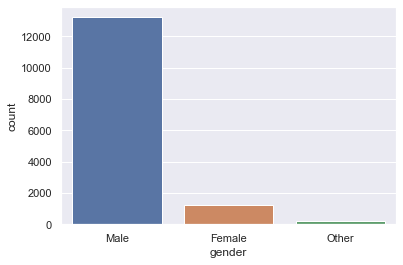

In [11]:
sns.countplot (data_train['gender'])
plt.savefig('Gender.png')
plt.show()

Kandidat yang berjenis kelamin laki-laki lebih banyak dibanding berjenis kelamin wanita

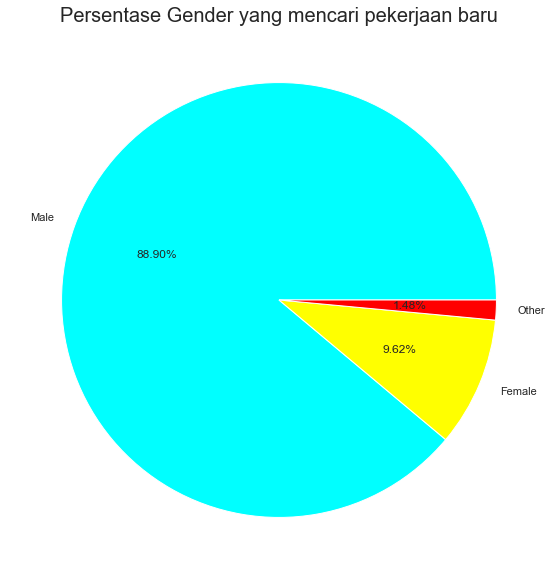

In [12]:
plt.figure(figsize=(10,10))
gender = data_train[data_train['target'] == 1] ['gender']
temp = gender.value_counts()
labels = temp.keys()
plt.pie(x = temp, labels = labels, colors = ['cyan', 'yellow', 'red'], autopct = '%.2f%%')
plt.title ('Persentase Gender yang mencari pekerjaan baru', fontsize = 20)
plt.show()

Kandidat yang berjenis kelamin laki-laki berjumlah **88.90%** sedangkan yang berjenis kelamin wanita **9.62%** dan lain-lain **1.48%**

C:\Users\Andisa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


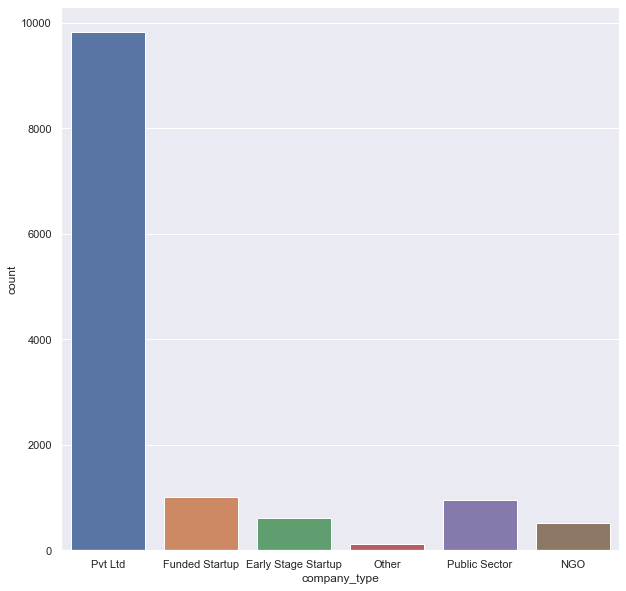

In [13]:
plt.figure(figsize=(10,10))
sns.countplot(data_train['company_type'])
plt.show()

Kebanyakan kandidat mencari jenis perusahaan Pvt Ltd. 

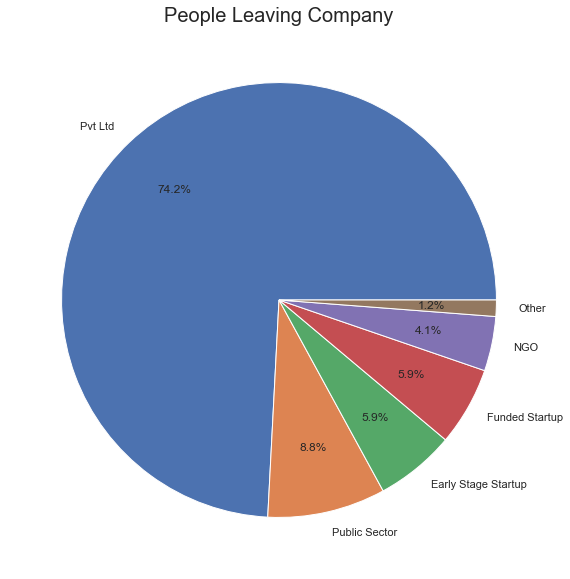

In [14]:
plt.figure(figsize=(10,10))
C_type = data_train[data_train['target'] == 1 ]['company_type']
temp = C_type.value_counts()
labels = temp.keys()
plt.pie(x = temp, labels = labels, autopct = '%.1f%%', pctdistance = 0.7)
plt.title('People Leaving Company', fontsize = 20)
plt.show()

In [15]:
for i in data_train['company_type'].unique():
    C_new = data_train[(data_train['company_type'] == i) & data_train['target'] == 1]
    print ('{} % of {} Yang mencari pekerjaan baru'.format(len(C_new)/len(data_train['company_type']==i)*100, i))

0.0 % of nan Yang mencari pekerjaan baru
9.2650589831924 % of Pvt Ltd Yang mencari pekerjaan baru
0.7307652155757386 % of Funded Startup Yang mencari pekerjaan baru
0.741204718655392 % of Early Stage Startup Yang mencari pekerjaan baru
0.15137279465497444 % of Other Yang mencari pekerjaan baru
1.096147823363608 % of Public Sector Yang mencari pekerjaan baru
0.5063158993631903 % of NGO Yang mencari pekerjaan baru


C:\Users\Andisa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='relevent_experience', ylabel='count'>

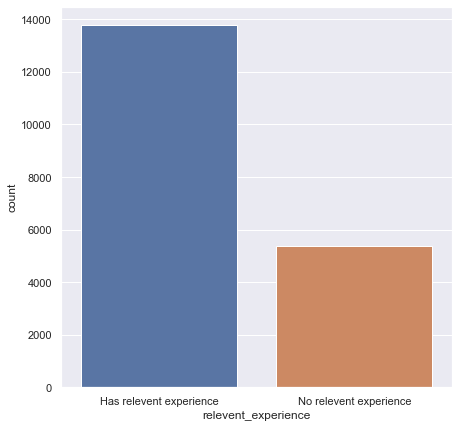

In [16]:
plt.figure(figsize=(7,7))
sns.countplot(data_train['relevent_experience'])

Orang yang memiliki pengalaman kerja lebih banyak mencari pekerjaan baru dibanding dengan yang tidak memiliki pengalaman kerja

C:\Users\Andisa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

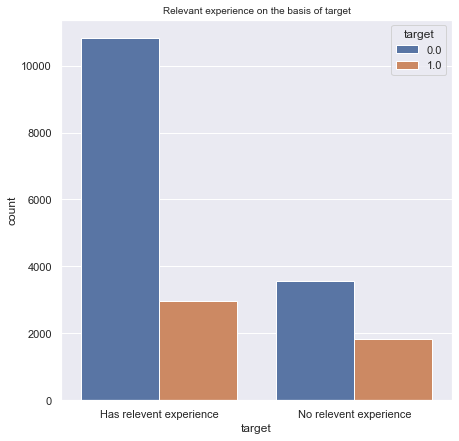

In [17]:
plt.figure(figsize=(7,7))
sns.countplot(data_train['relevent_experience'], hue = data_train['target'])
plt.xlabel ('target')
plt.ylabel ('count')
plt.title ('Relevant experience on the basis of target', fontsize = 10)
plt.show

*Keterangan : 0.0 -- Tidak mencari Pekerjaan Baru , 1.0 -- mencari pekerjaan baru*

C:\Users\Andisa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


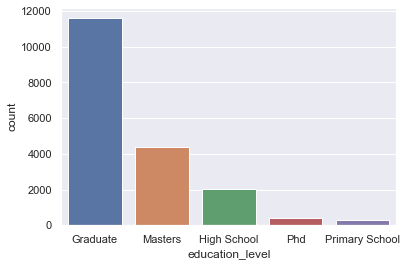

In [18]:
sns.countplot(data_train['education_level'])
plt.show()

In [19]:
ppl = data_train[(data_train['education_level'] == 'Primary School')& (data_train['education_level'] == 'High School')& (data_train['enrolled_university'] == 'no_enrollment')]

print ('Orang yang mencari kerja tanpa memiliki kelulusan universitas / gelar', len(ppl))

Orang yang mencari kerja tanpa memiliki kelulusan universitas / gelar 0


C:\Users\Andisa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='last_new_job', ylabel='count'>

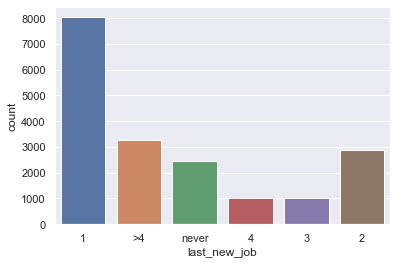

In [20]:
sns.countplot(data_train['last_new_job'])

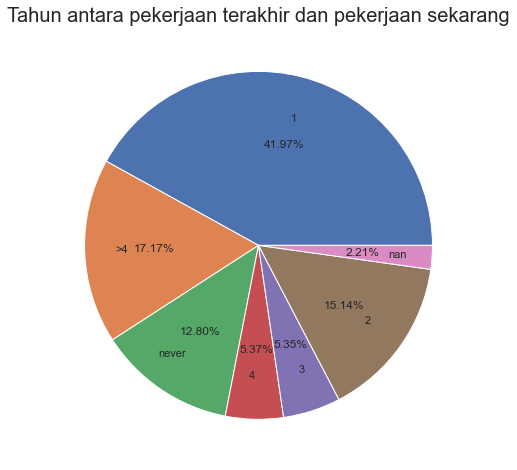

In [21]:
plt.figure(figsize=(8,8))
count = Counter(data_train['last_new_job'])
plt.pie(count.values(), labels = count.keys(), labeldistance = 0.75, autopct = lambda p:f'{p:.2f}%')
plt.title ('Tahun antara pekerjaan terakhir dan pekerjaan sekarang', fontsize = 20)
plt.show()

> ### Data Cleaning

In [22]:
# Null values Check data_train
data_train.isnull().sum()/len(data_train)*100

city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64

In [23]:
# Null Values Check data_test

data_test.isnull().sum()/len(data_test)*100

city                       0.000000
city_development_index     0.000000
gender                    23.860968
relevent_experience        0.000000
enrolled_university        1.456083
education_level            2.442461
major_discipline          14.654767
experience                 0.234852
company_size              29.215594
company_type              29.779239
last_new_job               1.878816
training_hours             0.000000
dtype: float64

In [24]:
#check missing value + percentage 
missing = data_train.isnull().sum().sort_values(ascending=False).reset_index()
missing.columns = ['features','missing_num']
missing['percentage'] = missing['missing_num']/data_train.shape[0]*100
missing

,features,missing_num,percentage
0,company_type,6140,32.049274
1,company_size,5938,30.994885
2,gender,4508,23.530640
3,major_discipline,2813,14.683161
4,education_level,460,2.401086
5,last_new_job,423,2.207955
6,enrolled_university,386,2.014824
7,experience,65,0.339284
8,target,0,0.000000
9,training_hours,0,0.000000


In [25]:
# fill missing data_train
data_train['experience'] = data_train['experience'].fillna('-1')
data_train['last_new_job'] = data_train['last_new_job'].fillna('-1')
data_train['enrolled_university'] = data_train['enrolled_university'].fillna('Unknown')
#data_train['gender'] = hrds_train_df['gender'].fillna('Unknown')
data_train['major_discipline'] = data_train['major_discipline'].fillna('Others')
data_train['education_level'] = data_train['education_level'].fillna('Unknown')
#data_train['company_size'] = data_train['company_size'].fillna('TBC')
#data_train['company_type'] = data_train['company_type'].fillna('TBC')
# COMPANY SIZE AND COMPANY TYPE NEEDS TO BE CODEDE USING RAMDOM METHOD TBC=TO BE CODED 
data_train.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,city_115,0.789,NaN,No relevent experience,Unknown,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [26]:
# fill missing data_test 
data_test['experience'] = data_test['experience'].fillna('-1')
data_test['last_new_job'] = data_test['last_new_job'].fillna('-1')
data_test['enrolled_university'] = data_test['enrolled_university'].fillna('Unknown')
#data_test['gender'] = data_test['gender'].fillna('Unknown')
data_test['major_discipline'] = data_test['major_discipline'].fillna('Others')
data_test['education_level'] = data_test['education_level'].fillna('Unknown')
#data_test['company_size'] = data_test['company_size'].fillna('TBC')
#data_test['company_type'] = data_test['company_type'].fillna('TBC')
# COMPANY SIZE AND COMPANY TYPE NEEDS TO BE CODEDE USING RAMDOM METHOD TBC=TO BE CODED 
data_test.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,city_21,0.624,Male,No relevent experience,no_enrollment,High School,Others,<1,NaN,Pvt Ltd,never,15
3,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [27]:
counts_1 = data_train["gender"].value_counts()
counts_1.head()

Male      13221
Female     1238
Other       191
Name: gender, dtype: int64

Lelaki ada **13221** orang, wanita ada **1238** orang dan lain-lain ada **191** orang

In [28]:
counts1 = data_train["company_size"].value_counts()
counts1.head()

50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
Name: company_size, dtype: int64

In [29]:
counts2 = data_train["company_type"].value_counts()
counts2.head()

Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Name: company_type, dtype: int64

In [30]:
def na_randomfill(series):
    na_mask = pd.isnull(series)   # boolean mask untuk null values
    n_null = na_mask.sum()        # number of nulls in the Series
    
    if n_null == 0:
        return series             # if there are no nulls, no need to resample
    
    # Randomly sample the non-null values from our series
    #  only sample this Series as many times as we have nulls 
    fill_values = series[~na_mask].sample(n=n_null, replace=True, random_state=0)

    # This ensures our new values will replace NaNs in the correct locations
    fill_values.index = series.index[na_mask]
    
    return series.fillna(fill_values)

In [31]:
out = na_randomfill(data_train["company_type"])
out_1 = na_randomfill(data_train["company_size"])
out_2 = na_randomfill(data_train["gender"])
# print(out)
data_train["company_type"] = out  
data_train["company_size"] = out_1
data_train["gender"] = out_2

In [32]:
out = na_randomfill(data_test["company_type"])
out_1 = na_randomfill(data_test["company_size"])
out_2 = na_randomfill(data_test["gender"])
# print(out)
data_test["company_type"] = out  
data_test["company_size"] = out_1
data_test["gender"] = out_2

In [33]:
counts_2 = data_train["gender"].value_counts()
counts_2.head()

Male      17302
Female     1615
Other       241
Name: gender, dtype: int64

In [34]:
missing = data_train.isnull().sum().sort_values(ascending=False).reset_index()
missing.columns = ['features','missing_num']
missing['percentage'] = missing['missing_num']/data_train.shape[0]
missing

,features,missing_num,percentage
0,target,0,0.0
1,training_hours,0,0.0
2,last_new_job,0,0.0
3,company_type,0,0.0
4,company_size,0,0.0
5,experience,0,0.0
6,major_discipline,0,0.0
7,education_level,0,0.0
8,enrolled_university,0,0.0
9,relevent_experience,0,0.0


In [35]:
counts3 = data_train["company_size"].value_counts()
counts3.head()

50-99        4432
100-500      3712
10000+       2938
10/49        2166
1000-4999    1938
Name: company_size, dtype: int64

In [36]:
counts4 = data_train["company_type"].value_counts()
counts4.head()

Pvt Ltd                14458
Funded Startup          1480
Public Sector           1398
Early Stage Startup      906
NGO                      745
Name: company_type, dtype: int64

> ### Encoding

In [37]:
# meng copy data 

data_test_copy=data_test.copy()
data_train_copy=data_train.copy()

In [38]:
display(data_train.head())
display(data_test.head())

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,1000-4999,Public Sector,1,36,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,500-999,Pvt Ltd,never,83,0.0
3,city_115,0.789,Male,No relevent experience,Unknown,Graduate,Business Degree,<1,500-999,Pvt Ltd,never,52,1.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,Pvt Ltd,1,21
1,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,100-500,Pvt Ltd,1,98
2,city_21,0.624,Male,No relevent experience,no_enrollment,High School,Others,<1,1000-4999,Pvt Ltd,never,15
3,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [109]:

# strip the 'city_' from city
data_test['city'] = data_test['city'].map(lambda x:int(x.strip().strip('city_')))
data_train['city'] = data_train['city'].map(lambda x:int(x.strip().strip('city_')))
data_test['city'] = data_test['city'].map(lambda x:int(x))
data_train['city'] = data_train['city'].map(lambda x:int(x))

# Fitting dan encoding kolom dengan label encoder
# membuat label encoder
le = LabelEncoder()

# gender kolom
le.fit(data_train["gender"])
data_train["gender"] = le.transform(data_train["gender"])
le.fit(data_test["gender"])
data_test["gender"] = le.transform(data_test["gender"])

# city kolom
le.fit(data_train["city"])
data_train["city"] = le.transform(data_train["city"])
le.fit(data_test["city"])
data_test["city"] = le.transform(data_test["city"])

# Encoding relevent_experience kolom
le.fit(data_train["relevent_experience"])
data_train["relevent_experience"] = le.transform(data_train["relevent_experience"])
le.fit(data_test["relevent_experience"])
data_test["relevent_experience"] = le.transform(data_test["relevent_experience"])

# Encoding enrolled_university kolom
le.fit(data_train["enrolled_university"])
data_train["enrolled_university"] = le.transform(data_train["enrolled_university"])
le.fit(data_test["enrolled_university"])
data_test["enrolled_university"] = le.transform(data_test["enrolled_university"])

# Encoding education_level kolom
le.fit(data_train["education_level"])
data_train["education_level"] = le.transform(data_train["education_level"])
le.fit(data_test["education_level"])
data_test["education_level"] = le.transform(data_test["education_level"])

# Encoding major_discipline kolom
le.fit(data_train["major_discipline"])
data_train["major_discipline"] = le.transform(data_train["major_discipline"])
le.fit(data_test["major_discipline"])
data_test["major_discipline"] = le.transform(data_test["major_discipline"])

# Encoding experience kolom
le.fit(data_train["experience"])
data_train["experience"] = le.transform(data_train["experience"])
le.fit(data_test["experience"])
data_test["experience"] = le.transform(data_test["experience"])

# Encoding company_size kolom
le.fit(data_train["company_size"])
data_train["company_size"] = le.transform(data_train["company_size"])
le.fit(data_test["company_size"])
data_test["company_size"] = le.transform(data_test["company_size"])

# Encoding company_type kolom
le.fit(data_train["company_type"])
data_train["company_type"] = le.transform(data_train["company_type"])
le.fit(data_test["company_type"])
data_test["company_type"] = le.transform(data_test["company_type"])

# Encoding last_new_job kolom
le.fit(data_train["last_new_job"])
data_train["last_new_job"] = le.transform(data_train["last_new_job"])
le.fit(data_test["last_new_job"])
data_test["last_new_job"] = le.transform(data_test["last_new_job"])

display(data_train.head())
display(data_test.head())


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,73,0.920,1,0,2,0,5,21,8,6,0,36,1.0
1,29725,27,0.776,1,1,2,0,5,6,4,5,4,47,0.0
2,11561,14,0.624,3,1,0,0,5,15,8,6,5,83,0.0
3,33241,81,0.789,3,1,3,0,1,20,8,5,5,52,1.0
4,666,113,0.767,1,0,2,2,5,21,4,1,3,8,0.0


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,25,0.827,1,0,0,0,5,19,7,6,0,21
1,9858,66,0.920,0,0,2,0,5,15,8,5,0,98
2,31806,11,0.624,1,1,2,1,6,20,8,5,5,15
3,27385,6,0.827,1,0,2,2,5,2,0,5,0,39
4,27724,66,0.920,1,0,2,0,5,21,3,5,4,72


> ### Procesing

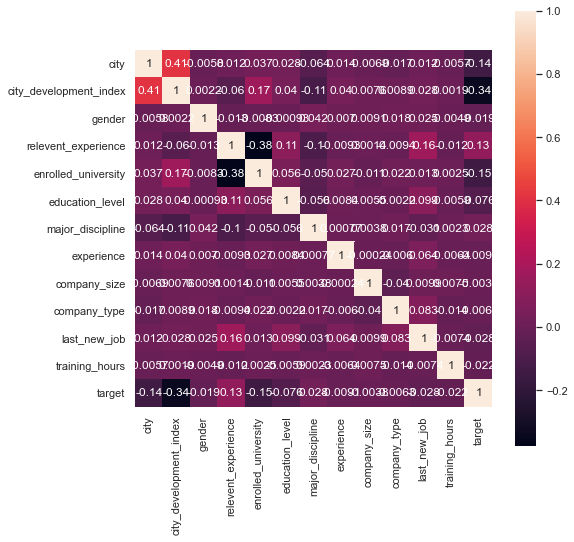

In [40]:
#initial check of correlation 
plt.figure(figsize=(8,8))
sns.heatmap((data_train).corr(), annot=True, square=True)
plt.show()


In [41]:
# menggenerate list kategori variabel yang kita miliki
train_catagory = data_train.dtypes[data_train.dtypes == "object"].index.tolist()


# mengecek unique value di tiap kolom
data_train[train_catagory].nunique()

Series([], dtype: float64)

In [42]:
counts5 = data_train["gender"].value_counts()
counts5.head()

1    17302
0     1615
2      241
Name: gender, dtype: int64

 **1 : Male**
 <br> **0 : Female**
 <br> **2 : Others**

In [43]:
X = data_train.drop("target" , axis =1)

y = data_train["target"]

print(X.shape,y.shape)

(19158, 12) (19158,)


## MACHINE LEARNING

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=2402)
X_train.shape

(14368, 12)

<AxesSubplot:xlabel='target', ylabel='count'>

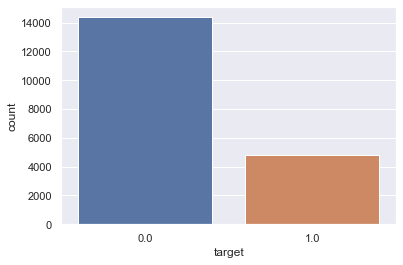

In [45]:
sns.countplot(x = "target" , data = data_train)

In [46]:
# resample data dengan menggunakan ROS
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({0.0: 10820, 1.0: 10820})

## MENCOBA RANDOM FOREST

In [47]:
# Fungsi untuk return confusion metrix dan accuracy score
def result_metrics(y_test, predicted, model):
    '''
    y_test adalah test data
    predicted adalah prediction
    model adalah model yang di gunakan untuk prediction
    '''
    # menghitung confusion matrix.
    cm = confusion_matrix(y_test, predicted)

    # membuat data frame dari confusion matrix.
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

    cm_df['model']=model

    # menghitung accuracy score
    acc_score = accuracy_score(y_test, predicted)

    # menampilkan hasil
    print("------------------------------------")
    print(f"Results for {model}")
    print("------------------------------------")
    print("Confusion Matrix:")
    display(cm_df)
    print("\n")
    accuracy_df = pd.DataFrame(classification_report(y_test, predicted,output_dict=True))
    accuracy_df['model'] = model
    print(f"Accuracy Score : {acc_score}\n")
    print("Classification Report")
    display(accuracy_df)    
    return cm_df,accuracy_df



In [48]:
# membuat random forest classifier.
rfc = RandomForestClassifier(random_state=2402)

In [49]:
# Fitting model
rfc_model = rfc.fit(X_train, y_train)

In [50]:
# menyimpan model
filename = 'rfc_model.sav'
pickle.dump(rfc_model, open(filename, 'wb'))

In [51]:
# membuat prediksi menggunakan testing data
predicted = rfc_model.predict(X_test)

In [52]:
# Menghitung keseimbangan accuracy score
rfc_m, rfc_acc = result_metrics(y_test, predicted, 'RandomForest')

------------------------------------
Results for RandomForest
------------------------------------
Confusion Matrix:


,Predicted 0,Predicted 1,model
Actual 0,3235,326,RandomForest
Actual 1,813,416,RandomForest




Accuracy Score : 0.7622129436325679

Classification Report


,0.0,1.0,accuracy,macro avg,weighted avg,model
precision,0.799160,0.560647,0.762213,0.679903,0.737963,RandomForest
recall,0.908453,0.338487,0.762213,0.623470,0.762213,RandomForest
f1-score,0.850309,0.422121,0.762213,0.636215,0.740446,RandomForest
support,3561.000000,1229.000000,0.762213,4790.000000,4790.000000,RandomForest


In [53]:
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'predicted: {predicted.shape}')


X_test: (4790, 12)
y_test: (4790,)
X_train: (14368, 12)
y_train: (14368,)
predicted: (4790,)


## LOGISTIC REGRESSION

In [54]:
X_resampled.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,73,0.920,1,0,3,0,6,22,3,5,4,88
1,50,0.754,1,0,3,0,6,4,4,1,4,40
2,9,0.698,1,0,3,2,6,8,6,5,3,135
3,6,0.550,1,0,3,0,6,16,0,4,1,42
4,44,0.802,1,0,3,0,6,16,4,5,1,46


In [55]:
# Train the Logistic Regression model menggunakan resampled data
lrc = LogisticRegression(solver='lbfgs', random_state=2402)
lrc.fit(X_resampled, y_resampled)

C:\Users\Andisa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=2402)

In [56]:
# Menghitung keseimbangan accuracy score
y_pred = lrc.predict(X_test)

In [57]:
lrc_m, lrc_acc = result_metrics(y_test, y_pred, 'LogisticRegression')

------------------------------------
Results for LogisticRegression
------------------------------------
Confusion Matrix:


,Predicted 0,Predicted 1,model
Actual 0,2354,1207,LogisticRegression
Actual 1,433,796,LogisticRegression




Accuracy Score : 0.6576200417536534

Classification Report


,0.0,1.0,accuracy,macro avg,weighted avg,model
precision,0.844636,0.397404,0.65762,0.621020,0.729887,LogisticRegression
recall,0.661050,0.647681,0.65762,0.654366,0.657620,LogisticRegression
f1-score,0.741651,0.492574,0.65762,0.617113,0.677744,LogisticRegression
support,3561.000000,1229.000000,0.65762,4790.000000,4790.000000,LogisticRegression


## XGB Classifier

In [58]:
xgbc = XGBClassifier(random_state =2402,use_label_encoder=True)
xgbc.fit(X_resampled, y_resampled)

C:\Users\Andisa\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              random_state=2402, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [59]:
# menghitung keseimbangan accuracy score
y_pred = xgbc.predict(X_test)

In [60]:
xgbc_m, xgbc_acc = result_metrics(y_test, y_pred, 'XGB Classifier')

------------------------------------
Results for XGB Classifier
------------------------------------
Confusion Matrix:


,Predicted 0,Predicted 1,model
Actual 0,2795,766,XGB Classifier
Actual 1,511,718,XGB Classifier




Accuracy Score : 0.7334029227557411

Classification Report


,0.0,1.0,accuracy,macro avg,weighted avg,model
precision,0.845433,0.483827,0.733403,0.664630,0.752653,XGB Classifier
recall,0.784892,0.584215,0.733403,0.684553,0.733403,XGB Classifier
f1-score,0.814038,0.529303,0.733403,0.671671,0.740982,XGB Classifier
support,3561.000000,1229.000000,0.733403,4790.000000,4790.000000,XGB Classifier


## Membandingkan Model

In [61]:
accuracy_df = pd.concat([rfc_acc,lrc_acc,xgbc_acc],axis=0)
confusion_df = pd.concat([rfc_m,lrc_m,xgbc_m])
print("Scores across all models")
display(accuracy_df.sort_values(by='accuracy',ascending=False))
print("\nConfusion metrics across all models")
display(confusion_df)

Scores across all models


,0.0,1.0,accuracy,macro avg,weighted avg,model
precision,0.799160,0.560647,0.762213,0.679903,0.737963,RandomForest
recall,0.908453,0.338487,0.762213,0.623470,0.762213,RandomForest
f1-score,0.850309,0.422121,0.762213,0.636215,0.740446,RandomForest
support,3561.000000,1229.000000,0.762213,4790.000000,4790.000000,RandomForest
precision,0.845433,0.483827,0.733403,0.664630,0.752653,XGB Classifier
recall,0.784892,0.584215,0.733403,0.684553,0.733403,XGB Classifier
f1-score,0.814038,0.529303,0.733403,0.671671,0.740982,XGB Classifier
support,3561.000000,1229.000000,0.733403,4790.000000,4790.000000,XGB Classifier
precision,0.844636,0.397404,0.657620,0.621020,0.729887,LogisticRegression
recall,0.661050,0.647681,0.657620,0.654366,0.657620,LogisticRegression



Confusion metrics across all models


,Predicted 0,Predicted 1,model
Actual 0,3235,326,RandomForest
Actual 1,813,416,RandomForest
Actual 0,2354,1207,LogisticRegression
Actual 1,433,796,LogisticRegression
Actual 0,2795,766,XGB Classifier
Actual 1,511,718,XGB Classifier


In [62]:
# Menghitung Fitur yang penting didalam random forest.
importances = rfc.feature_importances_
# We can sort the features by their importance.
sorted(zip(map(lambda x: round(x, 17),importances), X.columns), reverse=True)


[(0.23518360943699743, 'training_hours'),
 (0.17033115290572615, 'city_development_index'),
 (0.13755517274554183, 'experience'),
 (0.1002558687635618, 'company_size'),
 (0.0970003158871901, 'city'),
 (0.07384046582895634, 'last_new_job'),
 (0.04545971198133023, 'company_type'),
 (0.03366285278504864, 'enrolled_university'),
 (0.0313988388876136, 'education_level'),
 (0.03060492490802783, 'major_discipline'),
 (0.02321348356472311, 'relevent_experience'),
 (0.02149360230528305, 'gender')]

Text(0.5, 0, 'Random Forest Feature Importance')

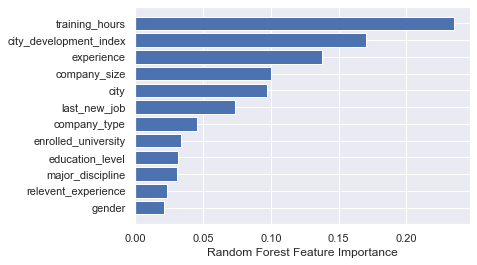

In [63]:
# Memasukan Bar Chart 
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(data_train.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [64]:
x = data_train.columns[sorted_idx]
y = rfc.feature_importances_[sorted_idx]
random_tree_values = pd.DataFrame(x,y)
random_tree_values.rename_axis('Values',inplace=True) 

random_tree_values.columns = ['Feature-Importances']
# random_tree_values.drop(random_tree_values.index[[2,7]])

random_tree_values = random_tree_values.drop(0.0970003158871901)
random_tree_values = random_tree_values.iloc[6:]

random_tree_values

,Feature-Importances
Values,
0.073840,last_new_job
0.100256,company_size
0.137555,experience
0.170331,city_development_index
0.235184,training_hours


In [65]:
random_tree_values.to_csv('Resources/Random_tree_features.csv')

## Validation

In [66]:
skfold = StratifiedKFold(n_splits = 5, random_state=2402, shuffle=True) 

rfc_cv = cross_val_score(rfc, X_train, y_train, cv = skfold, scoring='accuracy')
xgbc_cv = cross_val_score(xgbc, X_train, y_train, cv = skfold, scoring='accuracy')
lrc_cv = cross_val_score(lrc, X_train, y_train, cv = skfold, scoring='accuracy')

C:\Users\Andisa\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andisa\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andisa\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andisa\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andisa\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Andisa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Andisa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [67]:
# Mencari nilai cross val tiap model

print('CV Random Forest', rfc_cv) 
print('CV XG Boost', xgbc_cv) 
print('CV Gradient Boosting', lrc_cv)

CV Random Forest [0.77070285 0.77035491 0.76896312 0.7622694  0.77166725]
CV XG Boost [0.76409186 0.76965901 0.77244259 0.76644622 0.7688827 ]
CV Gradient Boosting [0.75469729 0.75887265 0.76200418 0.75704838 0.76192134]


In [68]:
# Mencari nilai rata2 cross val tiap model

print('Mean CV Random Forest', rfc_cv.mean())
print('Mean CV XG Boosting', xgbc_cv.mean())
print('Mean CV Gradient Boosting', lrc_cv.mean())

Mean CV Random Forest 0.7687915056820864
Mean CV XG Boosting 0.7683044766126979
Mean CV Gradient Boosting 0.758908766159921


In [69]:
RandomForestClassifier(random_state = 2402).get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2402,
 'verbose': 0,
 'warm_start': False}

In [70]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, 
                            param_grid = param_grid, 
                            cv = 3, 
                            n_jobs = -1,
                            verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2402),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

*note : 
<br>n_estimators = number of trees in the foreset
<br>max_features = max number of features considered for splitting a node
<br>max_depth = max number of levels in each decision tree
<br>min_samples_split = min number of data points placed in a node before the node is split
<br>min_samples_leaf = min number of data points allowed in a leaf node
<br>bootstrap = method for sampling data points (with or without replacement)

In [71]:
# Menampilkan best score dan best parameter

print('best score', grid_search.best_score_)
print('best params', grid_search.best_params_)

best score 0.7777005498421706
best params {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


In [72]:
rfc_tune = grid_search.best_estimator_.fit(X_test, y_test)
y_pred = rfc_tune.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.97      0.92      3561
         1.0       0.88      0.56      0.68      1229

    accuracy                           0.87      4790
   macro avg       0.87      0.77      0.80      4790
weighted avg       0.87      0.87      0.86      4790



In [73]:
#menyimpan model
filename = 'rfc_tune_model.sav'
pickle.dump(rfc_tune, open(filename, 'wb'))

## Menjalankan model kedalam test data set

In [74]:
data_test.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,25,0.827,1,0,0,0,6,20,7,5,1,21
1,66,0.920,0,0,3,0,6,16,1,5,1,98
2,11,0.624,1,1,3,1,5,21,2,5,6,15
3,6,0.827,1,0,3,2,6,3,0,5,1,39
4,66,0.920,1,0,3,0,6,22,3,5,5,72


In [75]:
# Making predictions using the testing data.
data_test_y = rfc_tune.predict(data_test)

In [76]:
data = {"prediction":np.unique(data_test_y),"count":np.unique(data_test_y,return_counts = True)[1]}
dataFrame = pd.DataFrame(data=data)
def categorize(x):
    if x == 0:
        return 'Likely to stay'
    else:
        return 'Likey to leave'
dataFrame.prediction = dataFrame.prediction.map(categorize)

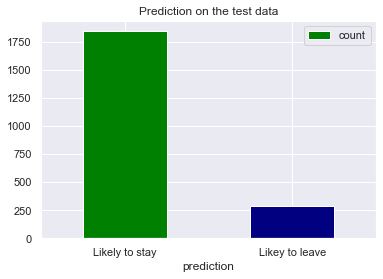

In [77]:
# Draw a vertical bar chart
dataFrame.plot.bar(x="prediction", y="count", rot=0, title="Prediction on the test data", color=("green", "navy"))
plt.show(block=True)

### SAVE MODEL

In [78]:
import joblib
joblib.dump(rfc_tune, 'ModelJoblib')

['ModelJoblib']

In [79]:
data_train.dtypes

city                        int64
city_development_index    float64
gender                      int32
relevent_experience         int32
enrolled_university         int32
education_level             int32
major_discipline            int32
experience                  int32
company_size                int32
company_type                int32
last_new_job                int32
training_hours              int64
target                    float64
dtype: object